<a href="https://colab.research.google.com/github/Sirabhop/Kaggle_Challenges/blob/master/Challenge_1_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns

from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report

import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
os.chdir("/content/drive/My Drive/My Project/Kaggle/Challenge#1_Titanic")

In [50]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The question is who gonna survive from shipwreak? from those features I can draw 3 assumption


1. **The number of sibling, children, & parent** are effected the chance of survive because the titanic passenger would do ever it take to save their relatives.
2. **The room** where passenger stayed affected too, the chance of survival may depend on how easy for them to acquire the emergency boat.
3. **The status of their ticket**, one who are VIP guest on board may thought the crew cabin would rushed out to help them instead of economics passengers.
4. **Embarkation** may determined their belongings which increase time to escape





###**Pivoting features**

####**Categorical features**

**Passenger  ticket**
![alt text](https://drive.google.com/uc?export=view&id=1l1VjKlR4mBE1D5Gd7xEN1HPeuU1aESQC)

In [35]:
df[['Pclass', 'Survived']].groupby(['Pclass']).mean().sort_values(by = 'Survived')

,Survived
Pclass,
3,0.242363
2,0.472826
1,0.626168


![Sea lanes of Titanic](https://drive.google.com/uc?export=view&id=1DLHzbthFAdZboIGqbsKPm5utA-PB8MSL)

the route start from Southampton (UK) > Cherbourg (FR) > Queenstown (IR)


In [45]:
df[['Embarked', 'Survived']].groupby(['Embarked']).mean().sort_values(by = 'Survived')

,Survived
Embarked,
S,0.336957
Q,0.389610
C,0.553571


In [42]:
df[['Sex', 'Survived']].groupby(['Sex']).mean().sort_values(by = 'Survived')

,Survived
Sex,
male,0.188908
female,0.740385


In [44]:
df[['SibSp', 'Survived']].groupby(['SibSp']).mean().sort_values(by = 'Survived', ascending = False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.343234
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [46]:
df[['Parch', 'Survived']].groupby(['Parch']).mean().sort_values(by = 'Survived', ascending = False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.341716
5,0.200000
4,0.000000
6,0.000000


####**Numerical features**

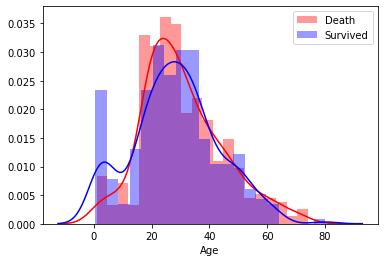

In [69]:
sns.distplot(df['Age'][df['Survived']==0], bins = 20, color = 'red', label = 'Death')
sns.distplot(df['Age'][df['Survived']==1], bins = 20, color = 'blue', label = 'Survived')
plt.legend()

plt.show()

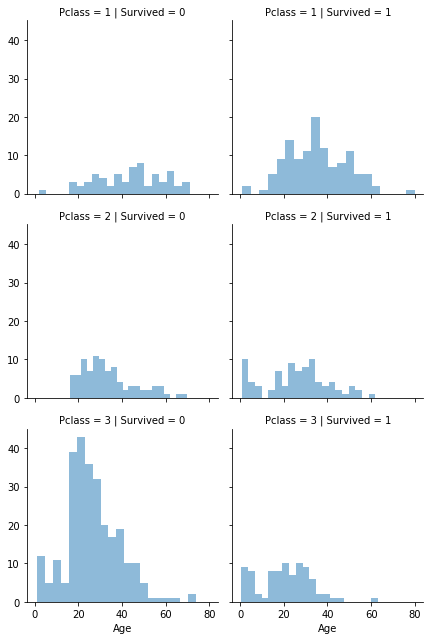

In [71]:
grid = sns.FacetGrid(df, col = 'Survived', row = 'Pclass')
grid.map(plt.hist, 'Age', alpha = 0.5, bins = 20)
grid.add_legend()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


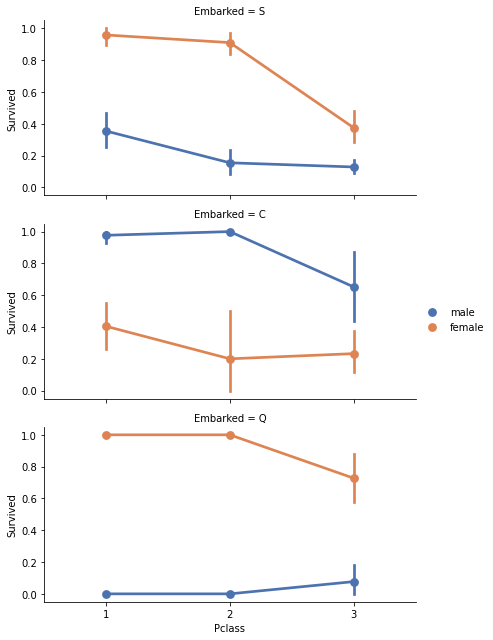

In [76]:
grid = sns.FacetGrid(df, row = 'Embarked', aspect = 2)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
grid.add_legend()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


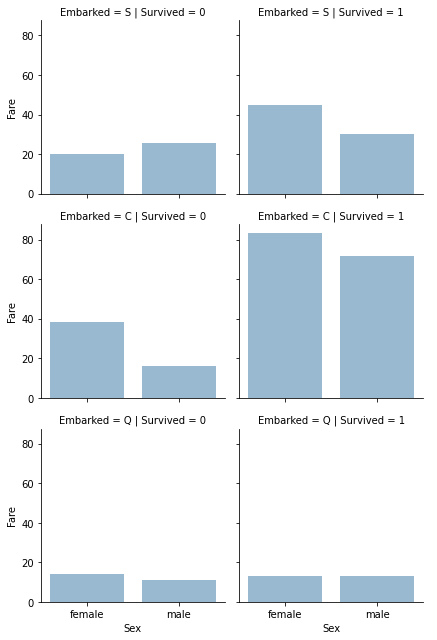

In [77]:
grid = sns.FacetGrid(df, row = 'Embarked', col = 'Survived')
grid.map(sns.barplot, 'Sex', 'Fare', alpha = 0.5, ci = None)
grid.add_legend()

In [78]:
df.drop(['Ticket', 'Cabin'], axis = 1, inplace = True)
test.drop(['Ticket', 'Cabin'], axis = 1, inplace = True)

In [106]:
combine = [df, test]
for dataset in combine:
  dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand = False)

In [107]:
pd.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [108]:
for dataset in combine:
  dataset['Title'].replace(
      ['Lady', 'Countess', 'Capt', 'Col',
       'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare', inplace = True)
  dataset['Title'].replace('Mlle', 'Miss', inplace = True)
  dataset['Title'].replace('Ms', 'Miss', inplace = True)
  dataset['Title'].replace('Mme', 'Mrs', inplace = True)

In [109]:
df[['Title', 'Survived']].groupby(['Title'], as_index = False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [19]:
embarked = pd.get_dummies(df['Embarked'], prefix = 'embarked')

df = pd.concat([df, embarked], axis = 1).drop(['Embarked', 'Pclass'], axis = 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 2:], df.iloc[:, 1], test_size = 0.2, random_state = 0)

In [21]:
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
y_pred = classifier.predict(X_test)

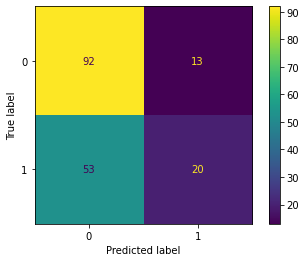

In [23]:
plot_confusion_matrix(classifier, X_test, y_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.88      0.74       105
           1       0.61      0.27      0.38        73

    accuracy                           0.63       178
   macro avg       0.62      0.58      0.56       178
weighted avg       0.62      0.63      0.59       178



In [ ]:
y_pred = classifier.predict(df)

In [ ]:
df['Fare'].fillna(df['Fare'].mean(), inplace = True)

In [ ]:
jay_submission_1 = pd.DataFrame(ID)

In [ ]:
jay_submission_1.drop(['#Survived'], axis = 1, inplace = True)

In [ ]:
jay_submission_1['Survived'] = y_pred

In [ ]:
jay_submission_1.replace({'Survived':0, 'Death':1}, inplace = True)

In [ ]:
jay_submission_1.to_csv('jay_submission_1.csv', index = False)

In [ ]:
jay_submission_1

,PassengerId,Survived
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1
